In [29]:
'''data'''
import pandas as pd
import numpy as np
import spacy
import re
import pickle
import pprint
from sklearn.pipeline import Pipeline

%run helpers.ipynb

'''Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns

''' Features'''
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

'''Estimators'''
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Modelling'''
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score 
from sklearn.metrics import roc_auc_score, f1_score, roc_curve, auc, confusion_matrix

## Import data

In [30]:
# read the SecReq datasets
CPN = pd.read_csv("../data/CPN.csv", sep=";", names=["text", "labels"])
GPS = pd.read_csv("../data/GPS.csv", sep=";", names=["text", "labels"])
ePurse = pd.read_csv("../data/ePurse_selective.csv", sep=";", names=["text", "labels"])

In [31]:
# read the nfr dataset
nfr = pd.read_csv("../data/nfr.csv")

## Process data in the labels column

**Examine the datasets**

In [32]:
CPN.shape, GPS.shape, ePurse.shape, nfr.shape

((210, 2), (178, 2), (124, 2), (625, 3))

In [33]:
CPN.head()

,text,labels
0,"Internally to the CPN, a CNG transmitting pri...","sec,,,,,"
1,"Internally to the CPN, a CNG receiving privat...","sec,,,,,"
2,The CNG shall detect the end of the life of th...,"sec,,,,,,"
3,A CPN-user attempting to invoke a CNG-mediate...,"sec,,,,,,"
4,The CNG shall implement an authentication fail...,"sec,,,,,,"


In [34]:
nfr.head()

,ProjectID,text,labels
0,1,The system shall refresh the display every 60 ...,PE
1,1,The application shall match the color of the s...,LF
2,1,If projected the data must be readable. On ...,US
3,1,The product shall be available during normal ...,A
4,1,If projected the data must be understandable...,US


In [35]:
datasets = [("CPN",CPN), ("GPS",GPS), ("ePurse",ePurse), ("nfr",nfr)] # a list of datasets

**Some basic cleaning**

In [36]:
# Clean some of the wierd ",,,,," in labels
def clean_labels(df):
    df["labels"] = df["labels"].map(lambda x: re.sub(",|\"","",str(x)))
    df['labels'] = df['labels'].astype(str)

In [37]:
for df in datasets[:-1]:
    clean_labels(df[1])

**Check to see if there is class imbalances for each dataset**

In [38]:
def level_counts(df):
    # count of each level
    count = df["labels"].value_counts(dropna=False)
    # percentage of each level
    percent = round(df["labels"].value_counts(dropna=False, normalize=True)*100, 3)
    
    # put it into a DataFrame
    return pd.concat([count,percent], axis=1, keys=["count", "percentage"])

In [39]:
for df in datasets:
    print(f"{df[0]}:")
    pprint.pprint(level_counts(df[1]))
    print("\n")

CPN:
        count  percentage
nonsec    167      79.524
sec        41      19.524
nan         2       0.952


GPS:
        count  percentage
nonsec     94      52.809
sec        45      25.281
nan        37      20.787
xyz         1       0.562
            1       0.562


ePurse:
        count  percentage
sec        83      66.935
nonsec     41      33.065


nfr:
    count  percentage
F     255       40.80
US     67       10.72
SE     66       10.56
O      62        9.92
PE     54        8.64
LF     38        6.08
A      21        3.36
SC     21        3.36
MN     17        2.72
L      13        2.08
FT     10        1.60
PO      1        0.16




**Let's drop the rows with label as nan in CPN and blank and xyz in GPS**

In [40]:
CPN = CPN.loc[(CPN["labels"] == "sec") | (CPN["labels"] == "nonsec") , :]  # highly imbalanced: 80% nonsec, 20% sec
GPS = GPS.loc[(GPS["labels"] == "sec") | (GPS["labels"] == "nonsec") , :]  # imbalanced: 67% nonsec, 32% sec
ePurse = ePurse.loc[(ePurse["labels"] == "sec") | (ePurse["labels"] == "nonsec") , :] # imbalanced: 66% nonsec, 33% sec

**For the nfr dataset, there are some labels with very little samples.  I can try to group all classes with less than 7% to a single "other" class"**

In [41]:
temp = level_counts(nfr)
others=list(temp[temp.percentage<5].index) # a list of classes that I want to group as "others"

In [42]:
nfr.loc[nfr.labels.isin(others), "labels"]= "others" 

In [43]:
level_counts(nfr)

,count,percentage
F,255,40.80
others,83,13.28
US,67,10.72
SE,66,10.56
O,62,9.92
PE,54,8.64
LF,38,6.08


**Combine CPN, GPS, ePurse datasets into a single SeqReq dataset.  We will perform binary classification on this dataset**

In [44]:
SecReq = pd.concat([CPN,GPS,ePurse], axis=0)

In [45]:
SecReq = SecReq.sample(frac=1).reset_index(drop=True)

In [46]:
SecReq.head()

,text,labels
0,"A CND, as defined in clause 3, may use the CNG...",nonsec
1,The CNG may support mechanisms supporting noma...,nonsec
2,When applicable a Security Domain shall Retur...,nonsec
3,"To ensure card security and integrity, the Gl...",sec
4,STB or media gateways should be equipped with ...,nonsec


## Process software requirements text
- Use spaCy to remove puncutation, non-alphanumric data, and elmmatize the text.
- Train and apply first-order phrase model to join word pairs (get bigrams).
- Train and apply second-order phrase model to join word triplets (get trigrams).
- Remove stopwords.
- Create tf-idf representations.

Useful reference: https://towardsdatascience.com/turbo-charge-your-spacy-nlp-pipeline-551435b664ad

In [47]:
nlp = spacy.load('en_core_web_sm')

In [48]:
%%time
# Process text
process_text(SecReq)
process_text(nfr)

Wall time: 5.24 s


## Phrase Modelling
- Learn combinations of tokens that together represents meaningful multi-word phrases ("United States", "happy hour")
- Use gensim to develop phrase models phrase models are developed by examining all the words in The headlines and looking for words that co-occur (i.e., appear one after another) together much more frequently than you would expect them to by random chance.
- Once our phrase model has been trained on our corpus, we can apply it to new text. When our model encounters two tokens in new text that identifies as a phrase, it will merge the two into a single new token.

Useful reference: https://towardsdatascience.com/another-twitter-sentiment-analysis-with-python-part-7-phrase-modeling-doc2vec-592a8a996867

In [49]:
# Train Phraser model, get bigrams
model_filepath = "../models/secreq_bigrams_model" # bigram model file path for SecReq
get_bigrams(SecReq, model_filepath, True)

model_filepath = "../models/nfr_bigrams_model" # bigram model file path for nfr
get_bigrams(nfr, model_filepath, True)

In [50]:
# Train Phraser model, get trigrams
model_filepath = "../models/secreq_trigrams_model" # bigram model file path for SecReq
get_trigrams(SecReq, model_filepath, True)

model_filepath = "../models/nfr_trigrams_model" # bigram model file path for nfr
get_trigrams(nfr, model_filepath, True)

In [51]:
SecReq.sample(5)

,text,labels,processed_text,bigrams,trigrams
221,Perform the calculation required to generate a...,sec,"[perform, calculation, require, generate, sign...","[perform, calculation, require, generate, sign...","[perform, calculation, require, generate, sign..."
55,The OPEN shall Ensure that application code h...,sec,"[open, shall, ensure, application, code, sign,...","[open, shall, ensure, application, code, sign,...","[open, shall, ensure, application, code, sign,..."
101,"At OP_READY state,Executable Load Files that ...",nonsec,"[ready, state, executable, load, file, include...","[ready, state, executable_load, file, include,...","[ready, state, executable_load_file, include, ..."
110,The CPN (trough CNDs and/or CNG) shall support...,nonsec,"[cpn, trough, cnd, cng, shall, support, manual...","[cpn, trough, cnd, cng, shall, support, manual...","[cpn, trough, cnd, cng, shall, support, manual..."
239,Any other type of command received shall be d...,nonsec,"[type, command, receive, shall, dispatch, curr...","[type, command, receive, shall, dispatch, curr...","[type, command, receive, shall, dispatch, curr..."


In [52]:
nfr.sample(5)

,ProjectID,text,labels,processed_text,bigrams,trigrams
361,7,The System shall allow entering storing and ...,F,"[system, shall, allow, enter, store, modify, p...","[system, shall, allow, enter, store, modify, p...","[system, shall, allow, enter, store, modify, p..."
395,8,The website will use standard Internet convent...,US,"[website, use, standard, internet, convention,...","[website, use, standard, internet, convention,...","[website, use, standard, internet, convention,..."
60,2,The system shall display clear property images...,F,"[system, shall, display, clear, property, imag...","[system, shall, display, clear, property, imag...","[system, shall, display, clear, property, imag..."
477,9,The leads washing functionality will validate ...,F,"[lead, wash, functionality, validate, lead, re...","[lead_wash, functionality, validate, lead, rec...","[lead_wash_functionality, validate, lead, rece..."
381,8,System shall let the administrator add/remove ...,PE,"[system, shall, let, administrator, add, remov...","[system, shall, let, administrator, add, remov...","[system, shall, let, administrator, add, remov..."


In [53]:
# Create a variant of the nfr dataset in which there are only two classes: functional (F) and non-functional (NF)
nfr_binary = nfr.copy()
nfr_binary["labels"].replace(["others","US","SE","O","PE","LF"], "NF", inplace=True)

In [55]:
# encode the labels to numeric value
encode_label(SecReq)
encode_label(nfr)
encode_label(nfr_binary)

In [56]:
secreq_texts = SecReq['trigrams'].astype('str')
nfr_texts = nfr_binary_texts = nfr['trigrams'].astype('str')

## Binary Classification for the SecReq dataset

**Pipeline for modelling**
- Convert the transformed text (with trigrams) to a matrix of tf-idf weights (features)
- The matrix would contain the tf-idf scores of each token t in each of the document in the corpus.
- Perform TruncatedSVD to reduce the number of features-- this is important since our sample size is small, a large feature set will lead to overfitting.
- Modelling: use RandomForest and Adaboost
- Tune hyperparameters with GridSearchCV

In [28]:
# Test harness
X = secreq_texts
y = SecReq['labels_num'].values 

# Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 10)

In [29]:
# Classifiers
models = {
    'SVC': SVC(random_state=10),
    'RandomForestClassifier': RandomForestClassifier(random_state=10),
    'AdaBoostClassifier': AdaBoostClassifier(random_state=10)
}

In [30]:
# Parameters for GridSearchCV
# Use a dictionary of dictionaries to set the param grid for each of the models
'''
SVC:
C = the regularization parameter, penalize model complexity
gamma = kernel coefficient for ‘rbf’ 


Random Forest:
n_estimators = number of trees in the foreset
max_features = max number of features considered for splitting a node
max_depth = max number of levels in each decision tree
min_samples_split = min number of data points placed in a node before the node is split
min_samples_leaf = min number of data points allowed in a leaf node

AdaBoost:
n_estimators = number of estimators in the boosted ensemble to use.
learning_rate= Learning rate shrinks the contribution of each classifier by learning_rate. 
'''       

# Parameters for GridSearchCV
params = {
    
    'SVC':  { 
        "clf__C" : [ 1, 10, 100, 1000], # [1,10,100,1000]
        "clf__gamma" : [1,0.1,0.001,0.0001], # [1,0.1,0.001,0.0001]
    },
    
    'RandomForestClassifier':  { 
        "clf__n_estimators" : [200, 400, 800, 1000, 1200], # [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800] 
        "clf__max_depth"      : [10,30,50,80,100],  # [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
        "clf__min_samples_split" : [2,5,10],  # [2, 5, 10]
        "clf__min_samples_leaf" :   [1,2,4]   # [1, 2, 4]  
    },
    
    'AdaBoostClassifier':  { 
        "clf__n_estimators" : [100, 500, 800, 1000], # [100, 500, 800, 1000]
        "clf__learning_rate" : [0.01,0.05,0.1,0.5,1] # [0.01,0.05,0.1,0.5,1]
    }
}

**Modelling**

In [31]:
df_secreq_tfidf = models_training("SecReq","tfidf", X_train, y_train, X_test, y_test, models, params, True)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    7.5s finished


The best parameters are: {'clf__C': 10, 'clf__gamma': 1}

The best accuracy score (on CV) are: 0.8754312354312355
Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 14.8min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 16.6min finished


The best parameters are: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}

The best accuracy score (on CV) are: 0.8085780885780884
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.0min finished


The best parameters are: {'clf__learning_rate': 1, 'clf__n_estimators': 800}

The best accuracy score (on CV) are: 0.8632634032634033


In [32]:
df_secreq_tfidf

,dataset,wv_type,model_name,accuracy_score,precision_score,recall_score,f1_score
0,SecReq,tfidf,SVC,0.880282,0.871087,0.867809,0.869393
2,SecReq,tfidf,AdaBoostClassifier,0.852113,0.845335,0.828593,0.835603
1,SecReq,tfidf,RandomForestClassifier,0.816901,0.830441,0.766645,0.783181


**Thoughts:**
- I should select SVC since it requires the least training time and it has the best performance (on the test data)**

## Binary Classification for the nfr_binary dataset

In [33]:
# Test harness
X = nfr_binary_texts
y = nfr_binary['labels_num'].values 

# Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 10)

**Modelling**

In [34]:
df_nfr_binary_tfidf = models_training("nfr_binary","tfidf", X_train, y_train, X_test, y_test, models, params, True)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    4.2s finished


The best parameters are: {'clf__C': 10, 'clf__gamma': 1}

The best accuracy score (on CV) are: 0.8695663531870428
Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 11.0min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 19.6min finished


The best parameters are: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 1200}

The best accuracy score (on CV) are: 0.8032131661442007
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   46.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.5min finished


The best parameters are: {'clf__learning_rate': 0.1, 'clf__n_estimators': 800}

The best accuracy score (on CV) are: 0.8352664576802507


In [35]:
df_nfr_binary_tfidf

,dataset,wv_type,model_name,accuracy_score,precision_score,recall_score,f1_score
0,nfr_binary,tfidf,SVC,0.877660,0.875415,0.870539,0.872730
1,nfr_binary,tfidf,RandomForestClassifier,0.835106,0.852122,0.810635,0.820870
2,nfr_binary,tfidf,AdaBoostClassifier,0.803191,0.811198,0.779630,0.787558


## Let's try to represent software requirements with pre-trained Sentence Embeddings 
Useful Reference: https://radimrehurek.com/gensim/models/keyedvectors.html

In [36]:
import gensim
from gensim.models import Word2Vec, KeyedVectors

In [37]:
%%time 
# Load KeyedVectors for the Google News word embeddings
# Contains 3 million 300-D word embeddings trained from 100 billion words

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
# The vectors is loaded from an existing file on disk in the original Google’s word2vec C format as 
#a KeyedVectors instance
googlew2v = KeyedVectors.load_word2vec_format('../embeddings/GoogleNews-vectors-negative300.bin.gz', 
                                                            binary=True) # C bin format

Wall time: 3min 30s


Since trained word vectors are independent from the way they were trained (Word2Vec, FastText, WordRank, VarEmbed etc), they can be represented by a standalone structure. The structure is called “KeyedVectors” and is essentially a mapping between entities and vectors. Each entity is identified by its string id, so this is a mapping between {str => 1D numpy array}. Note that with KeyVectors, I cannot continue to train the vectors.  However, KeyedVectors are smaller and need less RAM since htey don't need to store the model state that enbales training. 

In [38]:
# Convert the transformed requirements from each dataset a list of lists of tokens
nfr_docs = nfr.trigrams.tolist()
secreq_docs = SecReq.trigrams.tolist()

In [39]:
def get_sentence_embeddings(doc):
    # only keep tokens in each sentence if they are a vocab in googlew2v
    tokens_in_embedding= [t for t in doc if t in googlew2v] 
    sent_embedding = np.average([googlew2v[token] for token in tokens_in_embedding], axis=0)
    return sent_embedding

In [40]:
# Get the sentence embeddings of each of the 625 requirements in the nfr dataset
# For each requirements, I get the 300x1 word embedding for each token, and then take the average 
# to get a 300x1 sentence embedding
sent_embeddings_nfr= [get_sentence_embeddings(doc) for doc in nfr_docs] # a list of 625 ndarrays of 300 elements
sent_embeddings_nfr = np.concatenate(sent_embeddings_nfr, axis=0) # an ndarray of 625x300=187500 elements
sent_embeddings_nfr = sent_embeddings_nfr.reshape((625,300))

In [41]:
sent_embeddings_secreq = [get_sentence_embeddings(doc) for doc in secreq_docs] # a list of 471 ndarrays of 300 elements
sent_embeddings_secreq = np.concatenate(sent_embeddings_secreq, axis=0) # an ndarray of 471x300=141300 elements
sent_embeddings_secreq = sent_embeddings_secreq.reshape((471,300))

## Binary Classification for the SecReq dataset (with pre-trained word embeddings)

In [42]:
# Test harness
X = sent_embeddings_secreq
y = SecReq['labels_num'].values 

# Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 10)

In [43]:
df_secreq_wv = models_training("SecReq","pre_trained_wv", X_train, y_train, X_test, y_test, models, params, True)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    0.9s finished


The best parameters are: {'clf__C': 100, 'clf__gamma': 0.1}

The best accuracy score (on CV) are: 0.8785081585081584
Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 18.8min finished


The best parameters are: {'clf__max_depth': 30, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

The best accuracy score (on CV) are: 0.826946386946387
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.1min finished


The best parameters are: {'clf__learning_rate': 1, 'clf__n_estimators': 1000}

The best accuracy score (on CV) are: 0.8542191142191143


In [44]:
df_secreq_wv

,dataset,wv_type,model_name,accuracy_score,precision_score,recall_score,f1_score
2,SecReq,pre_trained_wv,AdaBoostClassifier,0.894366,0.884188,0.887417,0.885748
0,SecReq,pre_trained_wv,SVC,0.866197,0.858156,0.848201,0.852689
1,SecReq,pre_trained_wv,RandomForestClassifier,0.816901,0.809490,0.783883,0.793281


## Binary Classification for the nfr dataset (with pre-trained word embeddings)

In [45]:
# Test harness
X = sent_embeddings_nfr
y = nfr_binary['labels_num'].values 

# Train test split with stratified sampling for evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 10)

In [46]:
df_nfr_binary_wv = models_training("nfr_binary","pre_trained_wv", X_train, y_train, X_test, y_test, models, params, True)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    1.7s finished


The best parameters are: {'clf__C': 10, 'clf__gamma': 1}

The best accuracy score (on CV) are: 0.8490856844305121
Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   38.3s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 21.4min
[Parallel(n_jobs=-1)]: Done 1125 out of 1125 | elapsed: 23.9min finished


The best parameters are: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 1200}

The best accuracy score (on CV) are: 0.7827324973876697
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.5min finished


The best parameters are: {'clf__learning_rate': 1, 'clf__n_estimators': 500}

The best accuracy score (on CV) are: 0.8009143155694881


In [47]:
df_nfr_binary_wv

,dataset,wv_type,model_name,accuracy_score,precision_score,recall_score,f1_score
0,nfr_binary,pre_trained_wv,SVC,0.877660,0.875415,0.870539,0.872730
1,nfr_binary,pre_trained_wv,RandomForestClassifier,0.856383,0.868280,0.836609,0.845916
2,nfr_binary,pre_trained_wv,AdaBoostClassifier,0.787234,0.781991,0.774073,0.777146


## Results
- Let's take a look at the results through some data visualizations

In [49]:
binary_results = pd.concat([df_secreq_tfidf,df_nfr_binary_tfidf,df_secreq_wv,df_nfr_binary_wv], axis=0)

In [50]:
binary_results

,dataset,wv_type,model_name,accuracy_score,precision_score,recall_score,f1_score
0,SecReq,tfidf,SVC,0.880282,0.871087,0.867809,0.869393
2,SecReq,tfidf,AdaBoostClassifier,0.852113,0.845335,0.828593,0.835603
1,SecReq,tfidf,RandomForestClassifier,0.816901,0.830441,0.766645,0.783181
0,nfr_binary,tfidf,SVC,0.877660,0.875415,0.870539,0.872730
1,nfr_binary,tfidf,RandomForestClassifier,0.835106,0.852122,0.810635,0.820870
2,nfr_binary,tfidf,AdaBoostClassifier,0.803191,0.811198,0.779630,0.787558
2,SecReq,pre_trained_wv,AdaBoostClassifier,0.894366,0.884188,0.887417,0.885748
0,SecReq,pre_trained_wv,SVC,0.866197,0.858156,0.848201,0.852689
1,SecReq,pre_trained_wv,RandomForestClassifier,0.816901,0.809490,0.783883,0.793281
0,nfr_binary,pre_trained_wv,SVC,0.877660,0.875415,0.870539,0.872730


In [110]:
secreq_binary_results = binary_results[binary_results.dataset=="SecReq"] 
nfr_binary_results = binary_results[binary_results.dataset=="nfr_binary"] 

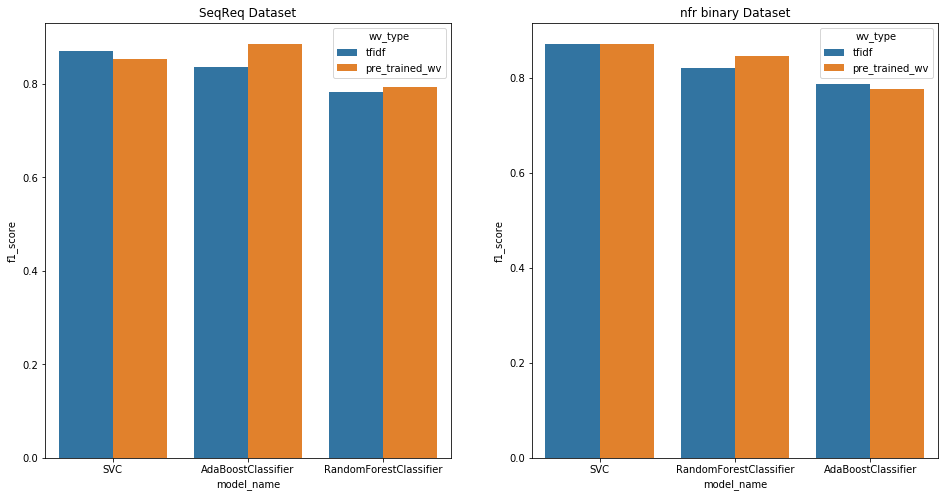

In [121]:
fig, axes = plt.subplots(1,2,figsize=(16,8))
sns.barplot(x="model_name", y="f1_score", hue="wv_type", data=secreq_binary_results, ax=axes[0])
sns.barplot(x="model_name", y="f1_score", hue="wv_type", data=nfr_binary_results, ax=axes[1])

axes[0].title.set_text('SeqReq Dataset')
axes[1].title.set_text('nfr binary Dataset')

plt.savefig("../outputs/binary_classification_results.jpeg")

## Thoughts
- In general, SVC should be used for this classification problem: it has the highest performance (measured by f1-score) for the SeqReq and nfr_binary datasets when tfidf is used, and it's performance is pretty close to Random Forest and Adaboost when pre-trained word-embeddings is used (but a lot less computational time is required).
- Pre-trained word embeddings did not improved the f1-score by much for neither datasets (in some cases, its performance decreased). This might be due to the fact that I took a average of all word embeddings in a document when I compute the document embeddings.  Perhaps I should take the weighted average instead, where the weights is computed by the tf-idf score of each word in the nfr/secreq corpora.
- Nonetheless, I believe the pre-trained word embeddings will be more using when they are combined into a embedding matrix and then used as an input to train the CNN model.
- In part 2, I will use the same statistical learning methods to train multi-class classifiers for the nfr dataset (with 5 non-functional classes).
- In part 3, I will use CNN with pre-trained word embeddings to perform binary and multi-class classifications.

## Outputs
- Save the processed datasets to be used in Part 2 and Part 3 of this project.
- Save the results of binary classification.

In [52]:
binary_results.to_csv("../outputs/binary_classification_results.csv", index=False)

In [57]:
SecReq.to_csv("../processed_data/SecReq_processed.csv", index=False)
nfr.to_csv("../processed_data/nfr_processed.csv", index=False)
nfr_binary.to_csv("../processed_data/nfr_binary_processed.csv", index=False)